In [3]:
!pip install dtreeviz

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.5/91.5 kB 2.3 MB/s eta 0:00:00


In [4]:
crds = '{"username":"ankitkanani","key":"094b4deedf1d7bef8637d4f1e0f19e02"}'

In [5]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [6]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(crds)
    cred_path.chmod(0o600)

In [7]:
from kaggle import api

if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 48.4M/48.4M [00:00<00:00, 92.8MB/s]


(#7) [Path('/root/.fastai/archive/bluebook-for-bulldozers/Valid.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/Test.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/Machine_Appendix.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/ValidSolution.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/median_benchmark.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/random_forest_benchmark_test.csv'),Path('/root/.fastai/archive/bluebook-for-bulldozers/TrainAndValid.csv')]

In [8]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

In [9]:
import numpy as np
import pandas as pd

In [10]:
# df = pd.read_csv("/kaggle/input/bluebook-for-bulldozers/TrainAndValid.csv", low_memory= False)
df = pd.read_csv(path/"TrainAndValid.csv", low_memory= False)


In [11]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [12]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [13]:
sizes = 'Large', 'Large/Medium', 'Medium', 'Small', 'Mini', 'Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered = True, inplace = True)

<ipython-input-13-ff316e50b17f>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [14]:
dep_var = 'SalePrice'

In [15]:
df[dep_var] = np.log(df[dep_var])

In [16]:
df[dep_var].head()

0    11.097410
1    10.950807
2     9.210340
3    10.558414
4     9.305651
Name: SalePrice, dtype: float64

In [17]:
from fastai.tabular.all import add_datepart
df=add_datepart(df, 'saledate')
df_test = pd.read_csv(path/'Test.csv')
df_valid = pd.read_csv(path/'Valid.csv')

df_test = add_datepart(df_test, 'saledate')
df_valid = add_datepart(df_valid, 'saledate')

In [18]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

We have a timeseries data. Therefore, we cant just create any randon validation set. We will use front part of the train data as train set and later some proportion of the df as validation set.

In [19]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,...,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,...,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,...,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,...,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,...,False,False,False,1.248307e+09


In [20]:
condition = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where(condition)[0]
valid_idx = np.where(~condition)[0]

In [21]:
splits = (list(train_idx), list(valid_idx))

In [22]:
from fastai.tabular.all import *

In [23]:
cont, cats = cont_cat_split(df, 1, dep_var = dep_var)

In [24]:
pocs = [Categorify, FillMissing]
to = TabularPandas(df, pocs, cats, cont, y_names=dep_var, splits= splits)

In [25]:
len(to.train), len(to.valid)

(404710, 7988)

In [26]:
to.show(5)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340
3,High,PC120-6E,PC120,#na#,-6E,#na#,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metric Tons",Texas,TEX,Track Excavators,#na#,EROPS w AC,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139251,1026470,332,121,3.0,2001,3486.0,2011,5,20,19,3,139,1.305763e+09,10.558414
4,Medium,S175,S175,#na#,#na#,#na#,#na#,Skid Steer Loader - 1601.0 to 1751.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,EROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139253,1057373,17311,121,3.0,2007,722.0,2009,7,30,23,3,204,1.248307e+09,9.305651


In [27]:
to.classes['ProductSize']

['#na#', 'Large', 'Large/Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [28]:
save_pickle('to.pkl', to)

In [29]:
to= load_pickle('to.pkl')

In [30]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [31]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [32]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs,y)

DecisionTreeRegressor(max_leaf_nodes=4)

In [33]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))


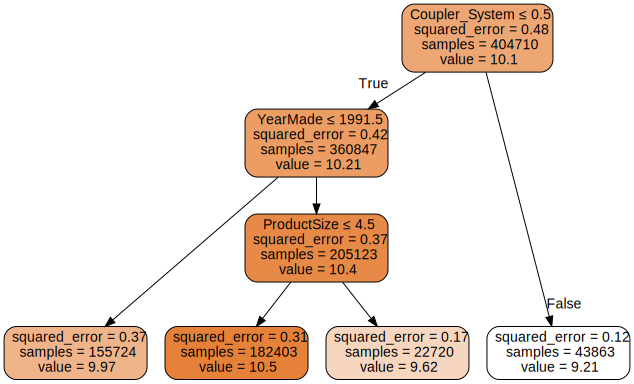

In [34]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)
# draw_tree(m, trn_xs, size=10)

### Lets try Disicion Tree without any limiting parameter

In [35]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [36]:
import math
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [37]:
m_rmse(m, xs, y)

0.0

In [38]:
valid_xs.shape, valid_y.shape

((7988, 66), (7988,))

In [39]:
m_rmse(m, valid_xs, valid_y)

0.337458

## Overfitting as the traning error is low and validation error is high, and the reason being is that at the every leaves, there are single data elemnet

In [40]:
m.get_n_leaves(), len(xs)

(324910, 404710)

In [41]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.239346, 0.313418)

# Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [43]:
m = rf(xs,y)

In [44]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.171285, 0.233735)

In [45]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X 

In [46]:
r_mse(preds.mean(0), valid_y)

0.233735

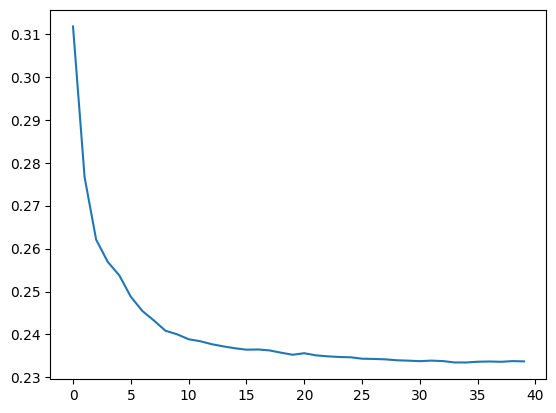

In [47]:
import matplotlib.pyplot as plt

# As we can see, more and more trees we add, error gets decreased gradually until at some point fo saturation
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)])

## Out of Bag Error


In [48]:
r_mse(m.oob_prediction_, y)

0.211239

In [49]:
preds_std = preds.std(0)


In [50]:
preds_std[:5]

array([0.29135796, 0.1391685 , 0.11472931, 0.25938995, 0.13270695])

## Feature Importance

In [51]:
def rf_feature_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending= False)

In [52]:
fi = rf_feature_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.174609
6,ProductSize,0.100652
30,Coupler_System,0.100477
7,fiProductClassDesc,0.080714
31,Grouser_Tracks,0.060887
54,ModelID,0.059776
65,saleElapsed,0.051411
3,fiSecondaryDesc,0.047196
1,fiModelDesc,0.035952
32,Hydraulics_Flow,0.032683


<Axes: ylabel='cols'>

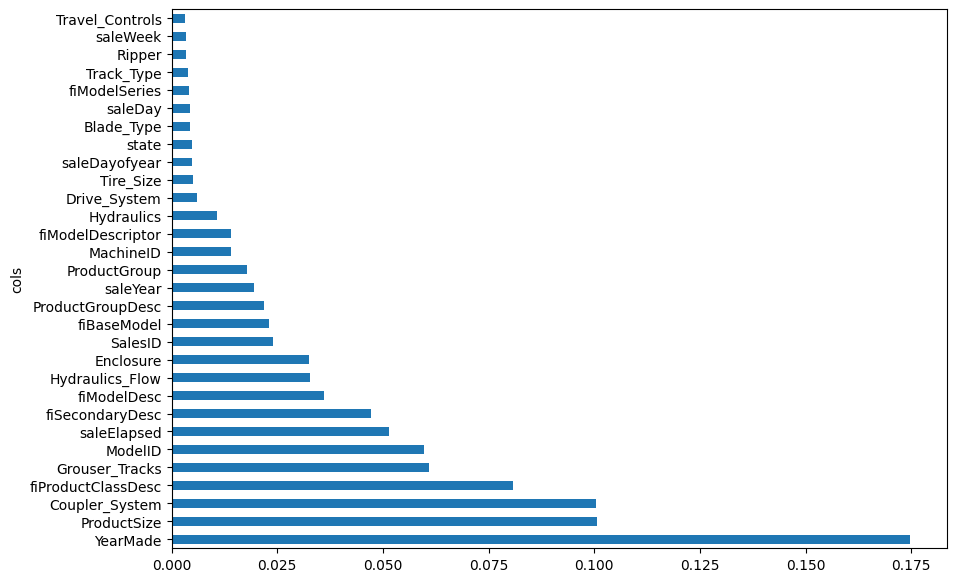

In [53]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(10,7), legend=False)
plot_fi(fi[:30])

In [54]:
# Removing the low importance feature
keep = fi[fi.imp>0.005].cols
keep

57              YearMade
6            ProductSize
30        Coupler_System
7     fiProductClassDesc
31        Grouser_Tracks
             ...        
53             MachineID
5      fiModelDescriptor
23            Hydraulics
11          Drive_System
28             Tire_Size
Name: cols, Length: 21, dtype: object

In [55]:
xs_imp = xs[keep]
valid_xs_imp  =valid_xs[keep]

In [56]:
m = rf(xs_imp, y)

In [57]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181718, 0.234163)

In [58]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

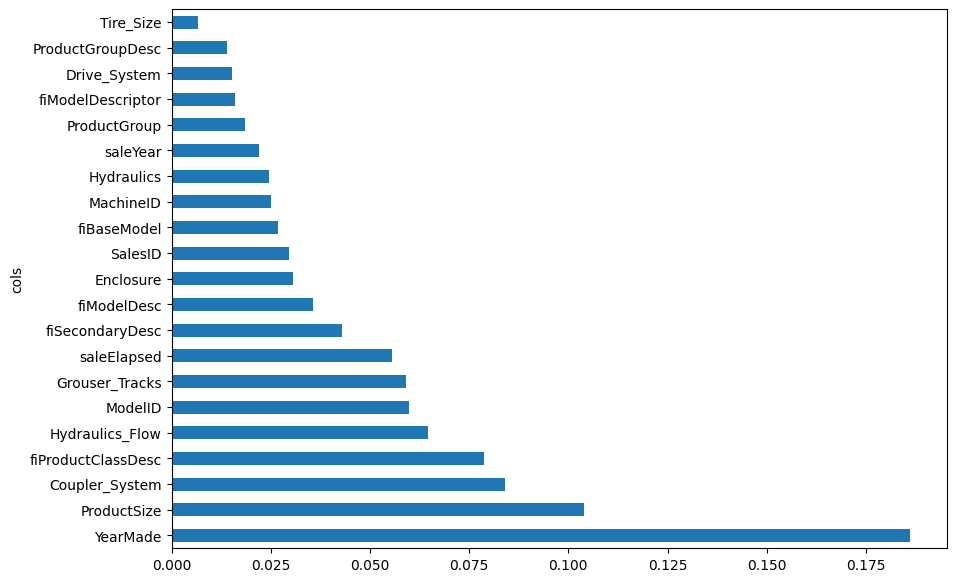

In [59]:
plot_fi(rf_feature_importance(m, xs_imp));

In [60]:
def get_oob(df):
    m = RandomForestRegressor (n_estimators=40, min_samples_leaf = 15, max_samples= 50000, max_features=0.5, n_jobs= -1, oob_score= True)
    m.fit(df,y)
    return m.oob_score_
get_oob(xs_imp)

0.8762262610238839

In [61]:
{c: get_oob(xs_imp.drop(c, axis=1)) for c in ('saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'saleYear': 0.8753167343811106,
 'saleElapsed': 0.8710568016408842,
 'ProductGroupDesc': 0.8756178438854872,
 'ProductGroup': 0.8759953327607057,
 'fiModelDesc': 0.8739355237716953,
 'fiBaseModel': 0.8751237738129299,
 'Hydraulics_Flow': 0.8768622603256492,
 'Grouser_Tracks': 0.8772599999633223,
 'Coupler_System': 0.8759531375057359}

In [62]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8729608294411803

In [63]:
xs_final = xs_imp.drop(to_drop, axis = 1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [64]:
save_pickle('xs_final.pkl', xs_final)
save_pickle('vallid_xs_final.pkl', valid_xs_final)

In [65]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183731, 0.233461)

([<matplotlib.axis.YTick at 0x7fc02cae5360>,
 [Text(0, 0, '#na#'),
  Text(0, 1, 'Large'),
  Text(0, 2, 'Large/Medium'),
  Text(0, 3, 'Medium'),
  Text(0, 4, 'Small'),
  Text(0, 5, 'Mini'),
  Text(0, 6, 'Compact')])

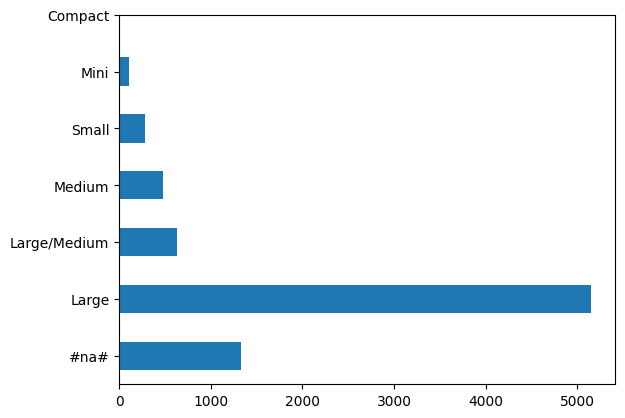

In [66]:
#count of values per category
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c)

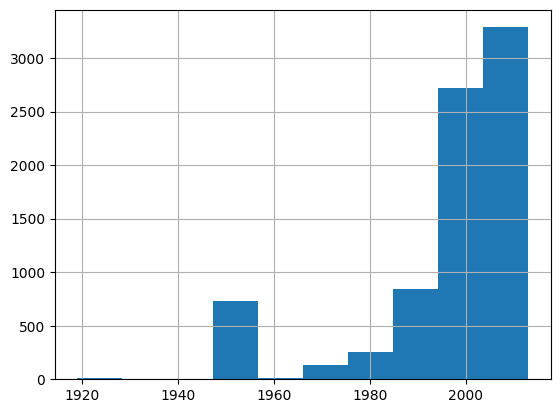

In [67]:
ax = valid_xs_final['YearMade'].hist()

In [68]:
!pip install --upgrade scikit-learn

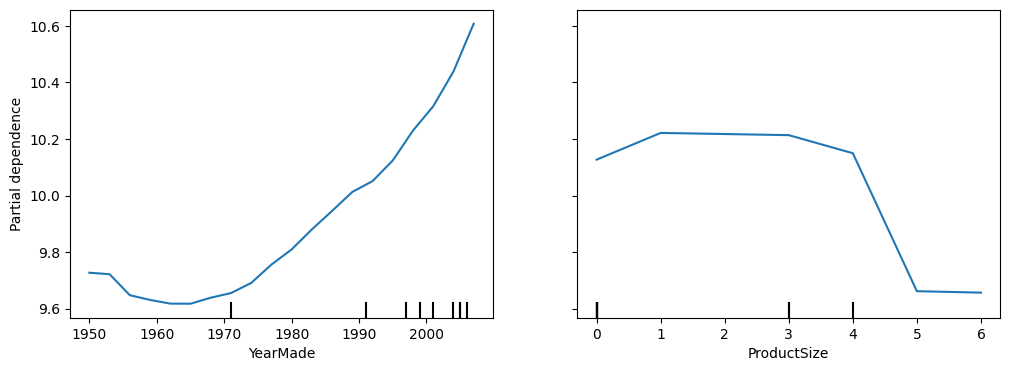

In [69]:
from sklearn.inspection import PartialDependenceDisplay


fig,ax = plt.subplots(figsize=(12, 4))
temp = PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax = ax)
# print(type(temp))
# print(temp)

In [70]:
!pip install treeinterpreter
!pip install waterfallcharts

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3389 sha256=559b16aba736963a82e84653dd8b0c672787c92260cc08a008e5a70ffa89aded
  Stored in directory: /root/.cache/pip/wheels/bd/34/6c/58fce34a3b8ec5607aff650db14ceb41db8223ac217423371b
Successfully built waterfallcharts


## Feature importance for individual example

In [71]:
# !pip install warnings
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [72]:
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [73]:
row = valid_xs_final.iloc[:5]

In [74]:
row

,YearMade,ProductSize,Coupler_System,fiProductClassDesc,...,fiModelDescriptor,Hydraulics,Drive_System,Tire_Size
22915,1950,3,0,48,...,0,1,0,0
22916,2006,0,0,2,...,17,0,2,0
22917,2006,0,2,41,...,0,4,0,0
22918,2003,0,2,44,...,0,4,0,0
22919,2007,0,0,1,...,0,0,2,0


In [75]:
predictions, bias,contributions = treeinterpreter.predict(m, row.values)

In [76]:
predictions[0], bias[0],contributions[0].sum()

(array([10.04021095]), 10.104300979932189, -0.06409002718479634)

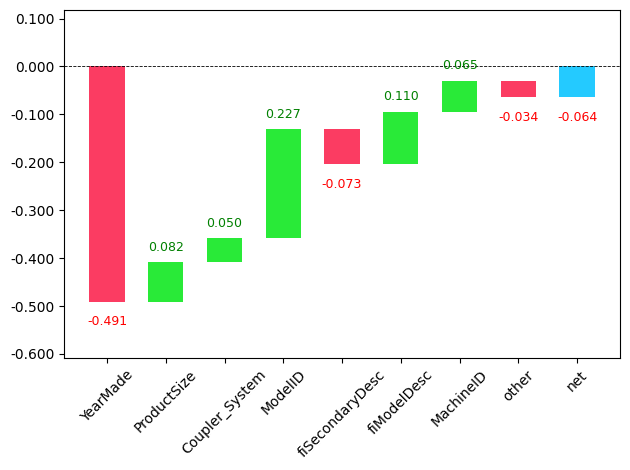

In [77]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
          rotation_value=45,formatting='{:,.3f}');

In [78]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

In [79]:
m = rf(df_dom, is_valid)
rf_feature_importance(m, df_dom)[:6]

,cols,imp
5,saleElapsed,0.919561
10,SalesID,0.067580
12,MachineID,0.007730
0,YearMade,0.002070
4,ModelID,0.000782
9,Enclosure,0.000413


In [80]:
m = rf(xs_final, y)
print('orig', m_rmse(m, valid_xs_final, valid_y))


orig 0.233716


In [81]:
for c in ('SalesID','saleElapsed','MachineID'):
    m = rf(xs_final.drop(c,axis=1), y)
    print(c, m_rmse(m, valid_xs_final.drop(c,axis=1), valid_y))

SalesID 0.231404
saleElapsed 0.236548
MachineID 0.232554


As above indicated, we can remove SalesID, MachineID as by removing them, model performance elivates slighlty.

In [82]:
time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_final_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse(m, valid_xs_final_time, valid_y)

0.231191

<Axes: >

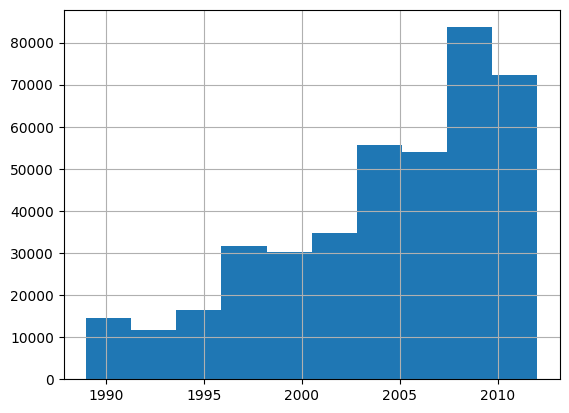

In [83]:
xs['saleYear'].hist()

In [84]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [85]:
m = rf(xs_filt, y_filt)
m_rmse(m, valid_xs_final_time, valid_y), m_rmse(m, xs_filt, y_filt)


(0.230951, 0.178259)

# Neural Network

In [87]:
dataset_path = path/"TrainAndValid.csv"
df_nn = pd.read_csv(dataset_path, low_memory= False)

In [88]:
df_nn.ProductSize= df_nn.ProductSize.astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, inplace= True, ordered = True)

In [89]:
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [90]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [91]:
cont_nn, cats_nn =cont_cat_split(df_nn_final, max_card = 9000, dep_var= dep_var)
cont_nn, cats_nn

(['saleElapsed'],
 ['YearMade',
  'ProductSize',
  'Coupler_System',
  'fiProductClassDesc',
  'ModelID',
  'fiSecondaryDesc',
  'fiModelDesc',
  'Hydraulics_Flow',
  'Enclosure',
  'ProductGroup',
  'fiModelDescriptor',
  'Hydraulics',
  'Drive_System',
  'Tire_Size'])

In [92]:
df_nn_final[cats_nn].nunique()

YearMade                73
ProductSize              5
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
fiModelDesc           5059
Hydraulics_Flow          3
Enclosure                6
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

In [93]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_final_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.177104, 0.23151)

In [94]:
# xs_filt3 = xs_filt.drop('fiModelDesc', axis=1)
# valid_xs_time3 = valid_xs_final_time.drop('fiModelDesc', axis=1)
# m3 = rf(xs_filt2, y_filt)
# m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)



In [95]:
cats_nn.remove('fiModelDescriptor')

In [96]:
pocs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, pocs_nn, cats_nn, cont_nn, splits= splits, y_names= dep_var)

In [97]:
dls = to_nn.dataloaders(1024)

In [98]:
y = to_nn.train.y
y.min(), y.max()

(8.465899, 11.863583)

SuggestedLRs(valley=0.0002754228771664202)

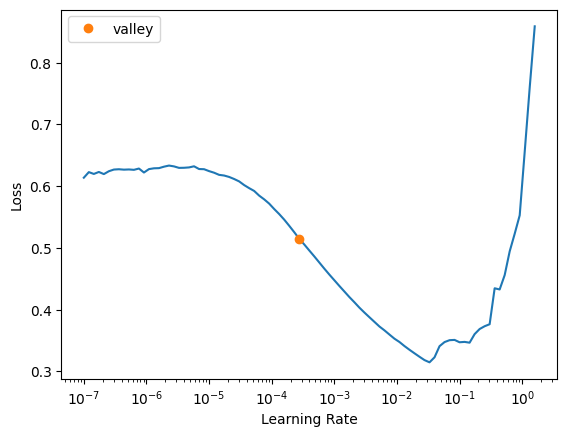

In [99]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,200], n_out=1, loss_func = F.mse_loss)
learn.lr_find()

In [100]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.061159,0.082921,00:05
1,0.053136,0.056992,00:04
2,0.048194,0.053553,00:04
3,0.042993,0.051723,00:05
4,0.040084,0.050174,00:04


In [101]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.223995

In [102]:
learn.save('nn')

Path('models/nn.pth')

In [103]:
tabular_learner??

In [104]:
rf_preds = m.predict(valid_xs_final_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

## best result so far

In [105]:
r_mse(ens_preds,valid_y)

0.22219

In [106]:
# tst_df = pd.read_csv(path/'test.csv')
# tst_df['Fare'] = tst_df.Fare.fillna(0)
# add_features(tst_df)

In [107]:
# tst_dl = learn.dls.test_dl(tst_df)

In [108]:
# preds,_ = learn.get_preds(dl=tst_dl)

In [109]:
# tst_df['Survived'] = (preds[:,1]>0.5).int()
# sub_df = tst_df[['PassengerId','Survived']]
# sub_df.to_csv('sub.csv', index=False)